## Murine bone-marrow derived macrophages

https://data.broadinstitute.org/bbbc/BBBC020/

## Make a torch dataset

In [1]:
from segmentation.datasets import BroadDataset

### Show some images

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#base = '/Users/nicholassofroniew/Documents/BBBC/BBBC020_v1/BBBC020_v1-cells'
base = '/Users/nicholassofroniew/Documents/DATA/neurofinder/mean'
train_dataset = BroadDataset(base, 'train')

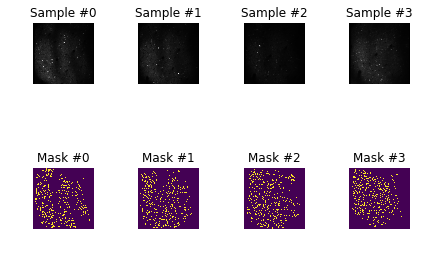

In [4]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

In [5]:
from numpy import asarray
tmp = asarray(img)
tmp.max()

255

## Define transforms

In [6]:
from torchvision import transforms
import segmentation.transforms as extended_transforms

joint_transform = extended_transforms.Compose([
    extended_transforms.RandomHorizontallyFlip(),
    extended_transforms.RandomVerticallyFlip(),
#    extended_transforms.CenterCrop(512),
#    extended_transforms.RandomRotate(45),
    extended_transforms.RandomWarp(5, 20)])

input_transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     ])
target_transform = extended_transforms.MaskToTensor()

In [7]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform)

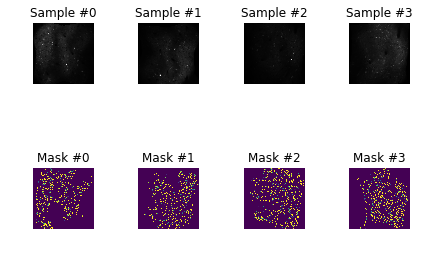

In [8]:
fig = plt.figure()

for i in range(len(train_dataset)):
    img, mask = train_dataset[i]

#    print(i, sample['image'].shape)

    ax = plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(img)
    ax = plt.subplot(2, 4, i + 5)
    ax.set_title('Mask #{}'.format(i))
    ax.axis('off')
    plt.imshow(mask)
    if i == 3:
        plt.show()
        break

In [9]:
train_dataset = BroadDataset(base, 'train', joint_transform=joint_transform, input_transform=input_transform, target_transform=target_transform)

In [10]:
from torch.utils.data import DataLoader
trainloader = DataLoader(train_dataset, batch_size=1,
                                          shuffle=True, num_workers=2)

## Load network

In [11]:
from segmentation.model import UNet

In [12]:
net = UNet(1)

In [13]:
net.train()

UNet (
  (enc1): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc2): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU (inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (5): ReLU (inplace)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    )
  )
  (enc3): _EncoderBlock (
    (encode): Sequential (
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
     

### Define loss function and optimizer

In [14]:
from segmentation.utilities import mIoULoss, CrossEntropyLoss2d, BCELoss2d

In [15]:
from torch import nn
criterion = mIoULoss(size_average=False)
#criterion = nn.NLLLoss2d()
#criterion = nn.BCEWithLogitsLoss()

In [16]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Pass data throuhg network

In [17]:
import torch.nn.functional as F
from torch.autograd import Variable
img, mask = train_dataset[0]
tmp = Variable(mask).unsqueeze(0)
foo = net(Variable(img).unsqueeze(0)).squeeze(0)

In [18]:
print(tmp)
print(foo)
#print(bar)

Variable containing:
( 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.LongTensor of size 1x512x512]

Variable containing:
( 0 ,.,.) = 
  1.4479e+00  1.6663e+00  1.6187e+00  ...   1.3266e+00  1.3851e+00  1.7466e+00
  1.6109e+00  1.6005e+00  1.5388e+00  ...   1.3860e+00  1.4373e+00  1.6027e+00
  1.6408e+00  1.5947e+00  1.5339e+00  ...   1.4026e+00  1.4558e+00  1.6029e+00
                 ...                   ⋱                   ...                
  1.1322e+00  1.2840e+00  1.2963e+00  ...   1.3651e+00  1.4571e+00  1.8228e+00
  1.1262e+00  1.2562e+00  1.2643e+00  ...   1.3351e+00  1.4297e+00  1.7972e+00
  1.1672e+00  1.2436e+00  1.2587e+00  ...   1.3472e+00  1.4378e+00  1.6282e+00
[torch.FloatTensor of size 1x512x512]



In [19]:
loss = criterion(foo, tmp)
print(loss)

Variable containing:
 94.0358
[torch.FloatTensor of size 1]



In [20]:
loss.backward()

### Train network

In [21]:
val_dataset = BroadDataset(base, 'train', input_transform=input_transform, target_transform=target_transform)

In [22]:
valloader = DataLoader(val_dataset, batch_size=1,
                                          shuffle=False, num_workers=2)

In [25]:
from segmentation.main import train, validate
from os.path import isdir, join
from os import mkdir

In [27]:
save_epoch = 1
epochs = 2

for epoch in range(epochs):  # loop over the dataset multiple times
        train(trainloader, net, criterion, optimizer, epoch, 18)
        # save out model every n epochs
        if save_epoch is not None:
            if epoch % save_epoch == save_epoch-1:
                snapshot_name = 'model-%04d' % epoch
                save_path = join(base, 'models-local', snapshot_name)
                if not isdir(save_path):
                    mkdir(save_path)
                validate(valloader, net, criterion, optimizer, True, save_path)  

[1,    18] loss: 89.237
Mean loss: 84.83 %
[2,    18] loss: 88.045
Mean loss: 84.19 %


### Load and save model

In [28]:
import torch
from os.path import join
snapshot_name = 'model-0899/model'

In [25]:
torch.save(net.state_dict(), join(base, 'models', snapshot_name + '.pth'))
#torch.save(optimizer.state_dict(), join(base, 'models', 'opt_' + snapshot_name + '.pth'))

In [29]:
netCompare = UNet(1)

In [30]:
netCompare.load_state_dict(torch.load(join(base, 'models', snapshot_name + '.pth'), map_location={'cuda:0': 'cpu'}))
#optimizer.load_state_dict(torch.load(join(base, 'models', 'opt_' + snapshot_name + '.pth'), map_location={'cuda:0': 'cpu'}))

In [142]:
net.train();

### Look at perforance on validation set

In [32]:
val_dataset = BroadDataset(base, 'train', input_transform=input_transform, target_transform=target_transform)

In [39]:
from torch.autograd import Variable
img, mask = val_dataset[0]
output = netCompare(Variable(img).unsqueeze(0))

In [40]:
prediction = F.sigmoid(output)

77.6775


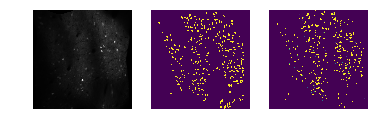

In [41]:
ax = plt.subplot(1,3,1);
plt.imshow(255*img.numpy().transpose(1,2,0))
ax.axis('off');
ax = plt.subplot(1,3,2);
plt.imshow(mask.numpy())
ax.axis('off');
ax = plt.subplot(1,3,3);
plt.imshow(prediction.squeeze(0).squeeze(0).data.numpy())
ax.axis('off');
loss = criterion(output, Variable(mask).unsqueeze(0))
print(loss.data.numpy()[0])

In [42]:
valloader = DataLoader(val_dataset, batch_size=1,
                                          shuffle=False, num_workers=2)

In [43]:
from skimage.io import imsave

In [ ]:
correct = 0
total = 0
ind = 0
for data in valloader:
    images, labels = data
    outputs = net(Variable(images))
    loss = criterion(outputs, Variable(labels)).data.numpy()[0]
    prediction = F.sigmoid(outputs)
    predict = prediction.squeeze(0).squeeze(0).data.numpy()
    #imsave(join(base, 'predictions','predict_%04d.tif' % ind), (255*predict).astype('uint8'), plugin='tifffile', photometric='minisblack')
    
    print(loss)
    total += labels.size(0)
    correct += loss
    ind += 1
    
print('Mean loss: %.2f %%' % (
    correct / total))

In [151]:
predict = prediction.squeeze(0).squeeze(0).data.numpy()

In [32]:
imsave(join(base, 'predict_0000.tif'), (255*predict).astype('uint8'), plugin='tifffile', photometric='minisblack')

In [33]:
predict.shape

(512, 512)